In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import norm
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import scipy as sc
import numdifftools as nd

In [142]:
import dill
dill.dump_session('./data_bruckner/data/notebookData/9_simulatingEquations.db')

TypeError: can't pickle traceback objects

In [6]:
import dill
dill.load_session('./data_bruckner/data/notebookData/9_simulatingEquations.db')

In [20]:
n_v = 100
corr_len = 10
integration_time = 500
learning_rate = 0.01

In [3]:
weights = 0.1*np.random.randn(integration_time+1,n_v)
#print weights

In [106]:
temp = 0
for t in range(integration_time):
    for i in range(n_v):
        for j in range(n_v):
            temp += weights[t,j]*np.exp(-abs((j-i)*1.0/corr_len))
        weights[t+1,i] = weights[t,i] + (temp)*learning_rate - 0.8*weights[t,i]
        temp = 0

KeyboardInterrupt: 

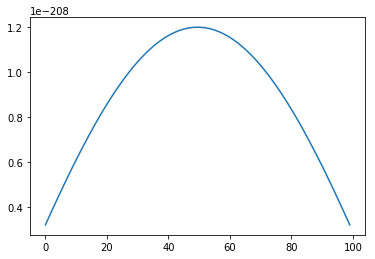

In [64]:
plt.plot(weights[500])

### Next order terms without 4 point correlator:

In [129]:
n_v = 100
corr_len = 3
integration_time = 1500
learning_rate = 10E-5

weights = 0.1*np.random.randn(integration_time+1,n_v) + 20*norm.pdf(x=np.linspace(0,99,100),loc=30,scale=5)
#print weights

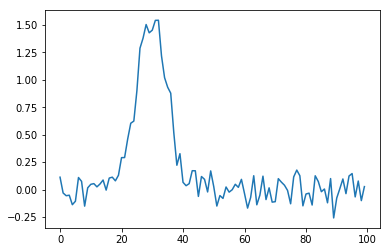

In [130]:
plt.plot(weights[0])

In [131]:
temp = 0
for t in range(integration_time):
    for i in range(n_v):
        for j in range(n_v):
            temp += (weights[t,j]*(1-(np.sum(weights[t,:]**2))/3) - (weights[t,j]**3)/3)*np.exp(-abs((j-i)*1.0/corr_len))
        weights[t+1,i] = weights[t,i] + (temp-weights[t,i]+(weights[t,i]**3)/3)*learning_rate
        temp = 0

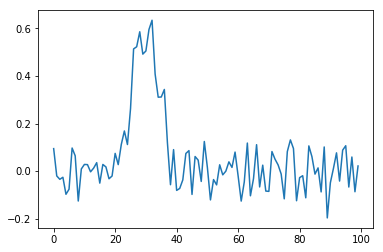

In [132]:
plt.plot(weights[-1])

## USE ODE INTEGRATOR

In [181]:
def order3(y,t,corr_len):
    dydt = np.zeros(len(y))
    temp = 0
    for i in range(len(y)):
        for j in range(len(y)):
            temp += y[j]*((1-(np.sum(y[:]**2))/3) - (y[j]**3)/3)*np.exp((-min(abs(j-i),(len(y)-abs(j-i))))*1.0/corr_len)
        dydt[i] = (temp - y[i] + (y[i]**3)/3)
        temp=0
    return dydt

In [192]:
#init_cond = 40*norm.pdf(x=np.linspace(0,99,100),loc=75,scale=5)
#init_cond = 0.1*np.random.randn(n_v)
init_cond = 1*np.sin(np.linspace(0,99,100)) + 0.1*np.random.randn(n_v)
time_int = np.linspace(0,200,10)
sol = odeint(order3, init_cond, time_int, args=(corr_len,))

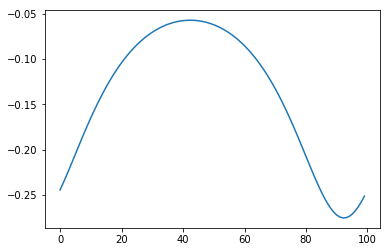

In [193]:
plt.plot(sol[-1,:])

## Use Remi's Equation

In [54]:
def Remi(y,t):
    dydt = (np.roll(y,1) + np.roll(y,-1))*0.5 + y**3 - y*np.sum(y**2)
    return dydt

In [55]:
init_cond = 40*norm.pdf(x=np.linspace(0,99,100),loc=75,scale=5)
#init_cond = 0.1*np.random.randn(n_v)
#init_cond = 1*np.sin(np.linspace(0,99,100)) + 0.1*np.random.randn(n_v)
time_int = np.linspace(0,50000,100)
sol_remi = odeint(Remi,init_cond,time_int)

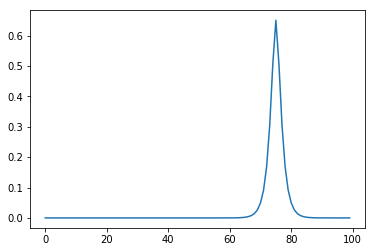

In [56]:
plt.plot(sol_remi[-1,:])

## Use my equation:

In [444]:
def Remi_Moshir(y,t):
    dydt = (np.roll(y,1) + np.roll(y,-1)) + (y**3 - y*np.sum(y**2))
    return dydt

In [480]:
#init_cond = 40*norm.pdf(x=np.linspace(0,99,100),loc=75,scale=5)
#init_cond = 0.1*np.random.randn(n_v)
init_cond = 1*np.sin(np.linspace(0,99,100)/2)
time_int = np.linspace(0,50000,10000)
sol_remi = odeint(Remi_Moshir,init_cond,time_int)

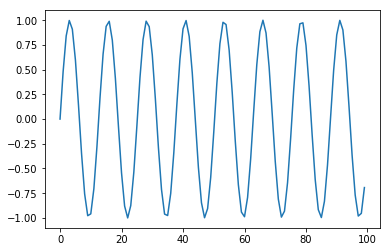

In [481]:
plt.plot(init_cond)

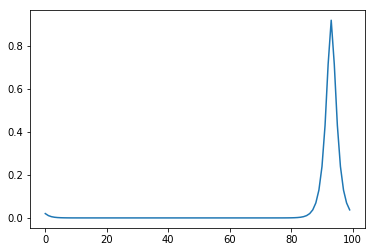

In [482]:
plt.plot(sol_remi[-1,:])

### Perturbation:

In [93]:
#init_cond = 40*norm.pdf(x=np.linspace(0,99,100),loc=75,scale=5)
init_cond = np.roll(sol_remi[-1],15)
#init_cond = 1*np.sin(np.linspace(0,99,100)) + 0.1*np.random.randn(n_v)
time_int = np.linspace(0,50000,10000)
sol_remi = odeint(Remi_Moshir,init_cond,time_int)

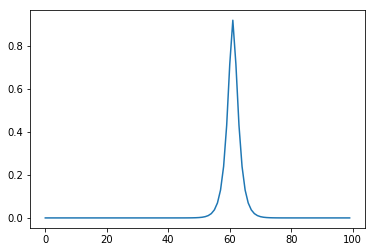

In [94]:
plt.plot(sol_remi[10,:])

### Pin one weight:

In [57]:
def Remi_Moshir_pin(y,t,pin):
    dydt = (np.roll(y,1) + np.roll(y,-1)) + (y**3 - y*np.sum(y**2))
    dydt[pin] = 0
    return dydt

In [64]:
#init_cond = 40*norm.pdf(x=np.linspace(0,99,100),loc=75,scale=5)

pin = 40
init_cond = 0.1*np.random.randn(n_v)
init_cond[pin] = 0.5

#init_cond = 1*np.sin(np.linspace(0,99,100)) + 0.1*np.random.randn(n_v)

time_int = np.linspace(0,50000,10000)
sol_remi = odeint(Remi_Moshir_pin,init_cond,time_int,args=(pin,))

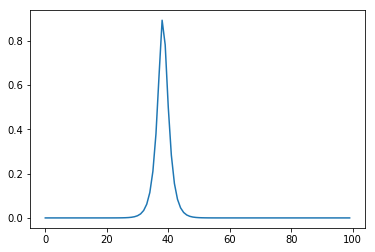

In [68]:
plt.plot(sol_remi[10,:])

## With correction term:

In [630]:
def Remi_Moshir_cube(y,t,beta):
    dydt = (np.roll(y,1) + np.roll(y,-1)) + (y**3 - y*np.sum(y**2)) - beta*((y**2)*(np.roll(y,1)+np.roll(y,-1)) - (np.roll(y,1)**3 + np.roll(y,-1)**3)/3)
    return dydt

In [631]:
beta = 0.001
#init_cond = 40*norm.pdf(x=np.linspace(0,99,100),loc=75,scale=5)
init_cond = 0.1*np.random.randn(n_v)
#init_cond = 1*np.sin(np.linspace(0,99,100)) + 0.1*np.random.randn(n_v)
time_int = np.linspace(0,50000,100)
sol_remi = odeint(Remi_Moshir_cube,init_cond,time_int,args=(beta,))

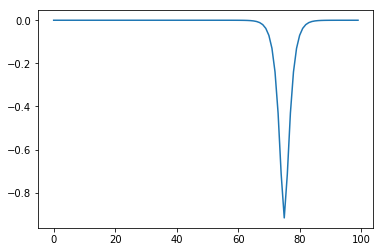

In [632]:
plt.plot(sol_remi[-1,:])

## With a noise term:

In [22]:
def Moshir_noise(y,t,noise):
    dydt = (np.roll(y,1) + np.roll(y,-1)) + (y**3 - y*np.sum(y**2)) + noise*y
    return dydt

In [37]:
noise = 0.1
init_cond = 0.1*np.random.randn(n_v)
time_int = np.linspace(0,50000,100)
sol_remi = odeint(Moshir_noise,init_cond,time_int,args=(noise,))

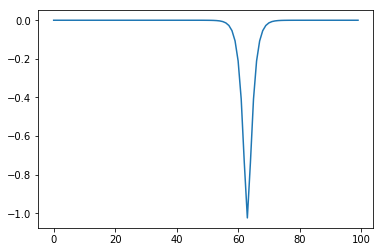

In [38]:
plt.plot(sol_remi[-1,:])

## Small Beta vs Correlation length:

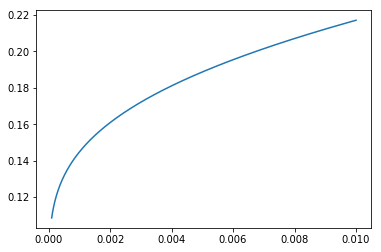

In [201]:
plt.plot(np.linspace(0.0001,0.01,1000),-1./(np.log(np.tanh(np.linspace(0.0001,0.01,1000)))))

In [203]:
-1./(np.log(np.tanh((0.000001))))

0.072382413650540225

## With Two hidden Units:

In [12]:
def Remi_Moshir2(y,t):
    dydt = np.zeros(len(y))
    dydt[0:len(y)/2] = (np.roll(y[0:len(y)/2],1) + np.roll(y[0:len(y)/2],-1) + (y[0:len(y)/2]**3 - y[0:len(y)/2]*np.sum(y[0:len(y)/2]**2)) + y[0:len(y)/2]*(y[len(y)/2:]**2) - y[len(y)/2:]*np.sum(y[0:len(y)/2]*y[len(y)/2:]))
    dydt[len(y)/2:] = (np.roll(y[len(y)/2:],1) + np.roll(y[len(y)/2:],-1) + (y[len(y)/2:]**3 - y[len(y)/2:]*np.sum(y[len(y)/2:]**2)) + y[len(y)/2:]*(y[0:len(y)/2]**2) - y[0:len(y)/2]*np.sum(y[0:len(y)/2]*y[len(y)/2:]))
    return dydt

In [20]:
#init_cond = 40*norm.pdf(x=np.linspace(0,198,100),loc=70,scale=5) + 10*norm.pdf(x=np.linspace(0,198,100),loc=120,scale=5)
init_cond = 0.1*np.random.randn(2*n_v)
#init_cond = 1*np.sin(np.linspace(0,99,100)) + 0.1*np.random.randn(n_v)
time_int = np.linspace(0,500000,100000)
sol_remi = odeint(Remi_Moshir2,init_cond,time_int)

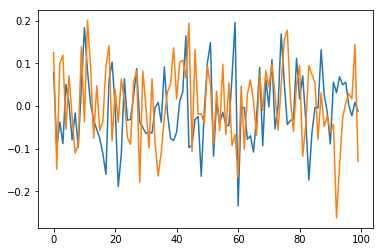

In [21]:
plt.plot(np.roll(init_cond[0:len(init_cond)/2],0))
plt.plot(np.roll(init_cond[len(init_cond)/2:],0))

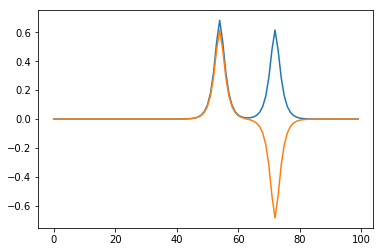

In [22]:
plt.plot(np.roll(sol_remi[-100,0:len(init_cond)/2],-20),)
plt.plot(np.roll(sol_remi[-100,len(init_cond)/2:],-20),)

## Beta Corrected First order expansion Terms in the partition function:

In [143]:
def Remi_Moshir2_corr(y,t,beta):
    dydt = np.zeros(len(y))
    
    corr1 = 2*beta*((y[0:len(y)/2]*y[len(y)/2:])*(y[0:len(y)/2] + y[len(y)/2:])*(np.sum(y[0:len(y)/2]*y[len(y)/2:])) - (y[0:len(y)/2]**2)*(y[len(y)/2:]**2)*(y[0:len(y)/2] + y[len(y)/2:]))
    
    dydt[0:len(y)/2] = (np.roll(y[0:len(y)/2],1) + np.roll(y[0:len(y)/2],-1) + (y[0:len(y)/2]**3 - y[0:len(y)/2]*np.sum(y[0:len(y)/2]**2)) + y[0:len(y)/2]*(y[len(y)/2:]**2) - y[len(y)/2:]*np.sum(y[0:len(y)/2]*y[len(y)/2:])) + corr1
    dydt[len(y)/2:] = (np.roll(y[len(y)/2:],1) + np.roll(y[len(y)/2:],-1) + (y[len(y)/2:]**3 - y[len(y)/2:]*np.sum(y[len(y)/2:]**2)) + y[len(y)/2:]*(y[0:len(y)/2]**2) - y[0:len(y)/2]*np.sum(y[0:len(y)/2]*y[len(y)/2:])) + corr1
    return dydt

In [196]:
#init_condC = 40*norm.pdf(x=np.linspace(0,198,100),loc=70,scale=5) + 10*norm.pdf(x=np.linspace(0,198,100),loc=120,scale=5)
#init_condC = 1*np.random.randn(2*n_v)

init_condC[0:len(init_condC)/2] = 1*np.sin(np.linspace(0,50,100)) + 0.1*np.random.randn(n_v)
init_condC[len(init_condC)/2:] = 1*np.sin(np.linspace(10,60,100)) + 0.1*np.random.randn(n_v)

time_int = np.linspace(0,10000000,1000000)
sol_remiC = odeint(Remi_Moshir2_corr,init_condC,time_int,args=(0.01,))

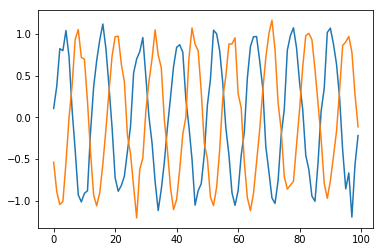

In [197]:
plt.plot(np.roll(init_condC[0:len(init_condC)/2],0))
plt.plot(np.roll(init_condC[len(init_condC)/2:],0))

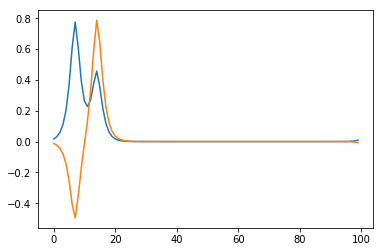

In [200]:
plt.plot(np.roll(sol_remiC[-1000,0:len(init_condC)/2],30))
plt.plot(np.roll(sol_remiC[-1000,len(init_condC)/2:],30))

## Beta second order corrected terms in the partition function:

In [1002]:
def Remi_Moshir2_corr2(y,t,beta):
    dydt = np.zeros(len(y))
    
    corr1 = 2*beta*((y[0:len(y)/2]*y[len(y)/2:])*(y[0:len(y)/2] + y[len(y)/2:])*(np.sum(y[0:len(y)/2]*y[len(y)/2:])) - (y[0:len(y)/2]**2)*(y[len(y)/2:]**2)*(y[0:len(y)/2] + y[len(y)/2:]))
    corr21 = (beta**2)*((y[0:len(y)/2]*(y[len(y)/2:]**2)*np.sum((y[0:len(y)/2]**2)*(y[len(y)/2:]**2))) - ((y[0:len(y)/2]**3)*(y[len(y)/2:]**4)))
    corr22 = (beta**2)*((y[len(y)/2:]*(y[0:len(y)/2]**2)*np.sum((y[0:len(y)/2]**2)*(y[len(y)/2:]**2))) - ((y[len(y)/2:]**3)*(y[0:len(y)/2]**4)))
    
    dydt[0:len(y)/2] = (np.roll(y[0:len(y)/2],1) + np.roll(y[0:len(y)/2],-1) + (y[0:len(y)/2]**3 - y[0:len(y)/2]*np.sum(y[0:len(y)/2]**2)) + y[0:len(y)/2]*(y[len(y)/2:]**2) - y[len(y)/2:]*np.sum(y[0:len(y)/2]*y[len(y)/2:])) + corr1 +corr21 
    dydt[len(y)/2:] = (np.roll(y[len(y)/2:],1) + np.roll(y[len(y)/2:],-1) + (y[len(y)/2:]**3 - y[len(y)/2:]*np.sum(y[len(y)/2:]**2)) + y[len(y)/2:]*(y[0:len(y)/2]**2) - y[0:len(y)/2]*np.sum(y[0:len(y)/2]*y[len(y)/2:])) + corr1 + corr22
    
    return dydt

In [1063]:
#init_condC = 40*norm.pdf(x=np.linspace(0,198,100),loc=70,scale=5) + 10*norm.pdf(x=np.linspace(0,198,100),loc=120,scale=5)
init_condC2 = 0.1*np.random.randn(2*n_v)

#init_condC2[0:len(init_condC2)/2] = 1*np.sin(np.linspace(0,50,100)) + 0.1*np.random.randn(n_v)
#init_condC2[len(init_condC2)/2:] = 1*np.sin(np.linspace(10,60,100)) + 0.1*np.random.randn(n_v)

time_int = np.linspace(0,500000,100000)
sol_remiC2 = odeint(Remi_Moshir2_corr2,init_condC2,time_int,args=(0.1,))

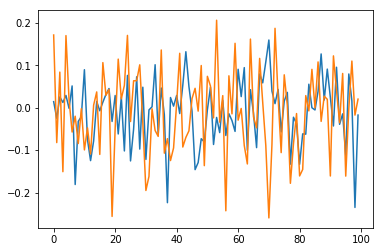

In [1064]:
plt.plot(np.roll(init_condC2[0:len(init_condC2)/2],0))
plt.plot(np.roll(init_condC2[len(init_condC2)/2:],0))

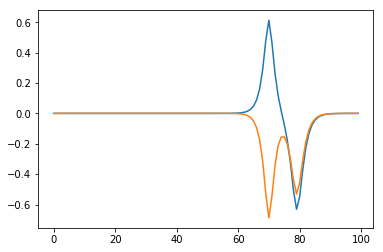

In [1065]:
plt.plot(np.roll(sol_remiC2[-1,0:len(init_condC2)/2],0))
plt.plot(np.roll(sol_remiC2[-1,len(init_condC2)/2:],0))

### Perturbation:

In [249]:
#init_cond = 40*norm.pdf(x=np.linspace(0,99,100),loc=75,scale=5)
roll_val = np.argmax(abs(sol_remi[-1,0:len(init_cond)/2])) - np.argmax(abs(sol_remi[-1,len(init_cond)/2:]))
init_cond[0:len(init_cond)/2] = sol_remi[-1,0:len(init_cond)/2]
init_cond[len(init_cond)/2:] = np.roll(sol_remi[-1,len(init_cond)/2:],roll_val)

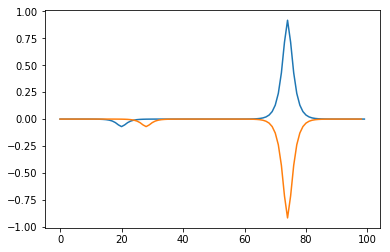

In [250]:
plt.plot(np.roll(init_cond[0:len(init_cond)/2],0))
plt.plot(init_cond[len(init_cond)/2:-1])

In [253]:
#init_cond = 1*np.sin(np.linspace(0,99,100)) + 0.1*np.random.randn(n_v)
time_int = np.linspace(0,50000,10000)
sol_remi2 = odeint(Remi_Moshir2,init_cond,time_int)

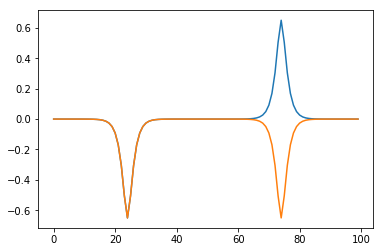

In [254]:
plt.plot(np.roll(sol_remi2[-1,0:len(init_cond)/2],0))
plt.plot(sol_remi2[-1,len(init_cond)/2:])

## Fit Gaussian:

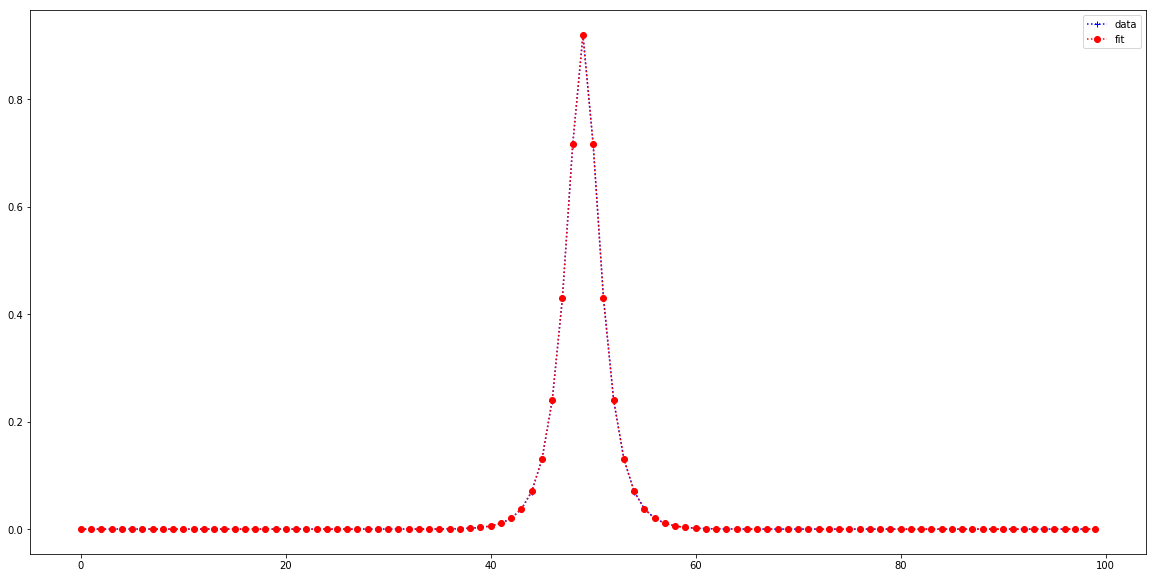

In [457]:
y = sol_remi[-1,:]
x = np.linspace(0,99,100)
n = len(x)
mean = sum(x*y)/(sum(y))
sigma = (sum(y*(x-mean)**2)/(sum(y)))**0.5

def gaus(x,a,x0,sigma,c):
    return a*np.exp(-((x-x0)**2+c**2)**0.5/(2*sigma))

popt,pcov = curve_fit(gaus,x,y,p0=[1,mean,sigma,0])

plt.figure(figsize=(20,10))
plt.plot(x,y,'b+:',label='data')
plt.plot(x,gaus(x,*popt),'ro:',label='fit')
plt.legend()
plt.show()

## Fit Lorenzian:

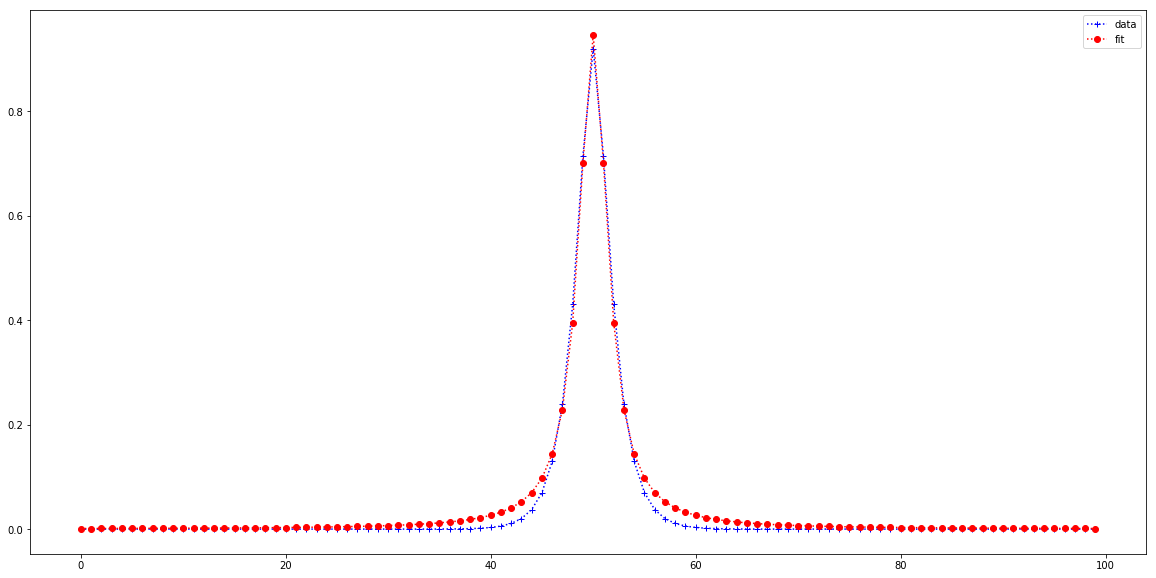

In [327]:
def Lorenzian(x,a,x0,sigma):
    return a*(sigma/((x-x0)**2 + sigma**2))/np.pi

popt2,pcov2 = curve_fit(Lorenzian,x,y,p0=[sigma*np.pi,mean,sigma])

plt.figure(figsize=(20,10))
plt.plot(x,y,'b+:',label='data')
plt.plot(x,Lorenzian(x,*popt2),'ro:',label='fit')
plt.legend()
plt.show()

## Fit Sum of Two Exponential Function:

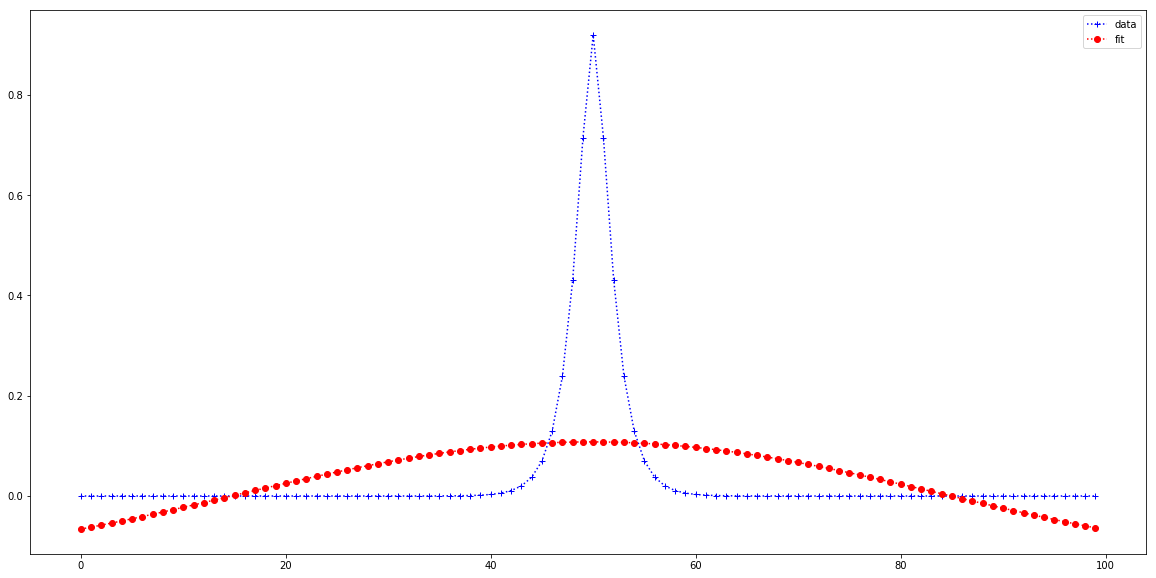

In [402]:
from numpy import exp
def expSum(x,a,b,c,d,x0,k):
    #t = (a+1j*b)*exp(-1j*k*(x-x0)) + ((a+1j*b)*exp(2j*k*x0)*(1-exp(-1j*k*len(x)))/(exp(1j*k*len(x))-1))*exp(1j*k*(x-x0))
    t = (a+1j*b)*exp(-1j*k*(x-x0)) + (c+1j*d)*exp(1j*k*(x-x0))
    return t.real
    
    
popt3,pcov3 = curve_fit(expSum,x,y,p0=[10,4,-10,-1,mean,1/sigma])

plt.figure(figsize=(20,10))
plt.plot(x,y,'b+:',label='data')
plt.plot(x,expSum(x,*popt3),'ro:',label='fit')
plt.legend()
plt.show()

In [336]:
print expSum(x,max(y)/2,max(y/2),mean,sigma)

TypeError: only length-1 arrays can be converted to Python scalars

## Fourier Transform:

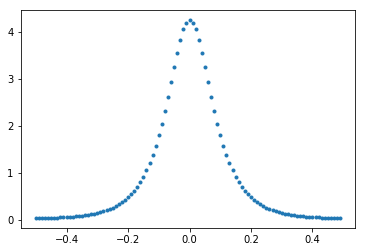

In [442]:
sp = np.fft.fft(y)
freq = np.fft.fftfreq(len(y))
plt.plot(freq,abs(sp.real),)

## With all the terms two hidden units interaction terms without expansion:

In [685]:
def Remi_Moshir2_full(y,t,beta):
    
    dydt = np.zeros(len(y))
    
    #Full Interaction terms:
    p1 = np.prod(1 + sc.tanh(y[0:len(y)/2]*(beta**0.5))*sc.tanh(y[len(y)/2:]*(beta**0.5)))
    p2 = np.prod(1 - sc.tanh(y[0:len(y)/2]*(beta**0.5))*sc.tanh(y[len(y)/2:]*(beta**0.5)))
    
    c1 = p1/(1 + sc.tanh(y[0:len(y)/2]*(beta**0.5))*sc.tanh(y[len(y)/2:]*(beta**0.5)))
    c2 = p2/(1 - sc.tanh(y[0:len(y)/2]*(beta**0.5))*sc.tanh(y[len(y)/2:]*(beta**0.5)))
    
    corr1 = (sc.tanh(y[len(y)/2:]*(beta**0.5)))*(1-(sc.tanh(y[0:len(y)/2]*(beta**0.5)))**2)*(c1-c2)/(p1 + p2)
    corr2 = (sc.tanh(y[0:len(y)/2]*(beta**0.5)))*(1-(sc.tanh(y[len(y)/2:]*(beta**0.5)))**2)*(c1-c2)/(p1 + p2)
    
    #First order beta correction due to data:
    #corr12 = beta*((y[0:len(y)/2]**2)*(np.roll(y[0:len(y)/2],1)+np.roll(y[0:len(y)/2],-1)) - (np.roll(y[0:len(y)/2],1)**3 + np.roll(y[0:len(y)/2],-1)**3)/3)
    #corr22 = beta*((y[len(y)/2:]**2)*(np.roll(y[len(y)/2:],1)+np.roll(y[len(y)/2:],-1)) - (np.roll(y[len(y)/2:],1)**3 + np.roll(y[len(y)/2:],-1)**3)/3)
    
    dydt[0:len(y)/2] = (np.roll(y[0:len(y)/2],1) + np.roll(y[0:len(y)/2],-1) + (y[0:len(y)/2]**3 - y[0:len(y)/2]*np.sum(y[0:len(y)/2]**2)) - corr1/(beta**1.5)) 
    dydt[len(y)/2:] = (np.roll(y[len(y)/2:],1) + np.roll(y[len(y)/2:],-1) + (y[len(y)/2:]**3 - y[len(y)/2:]*np.sum(y[len(y)/2:]**2)) - corr2/(beta**1.5))
    
    return dydt

In [686]:
#init_cond = 40*norm.pdf(x=np.linspace(0,198,100),loc=70,scale=5) + 10*norm.pdf(x=np.linspace(0,198,100),loc=120,scale=5)
init_cond = 0.05*np.random.randn(2*n_v)
#init_cond = 1*np.sin(np.linspace(0,198,200)) + 0.1*np.random.randn(2*n_v)
time_int = np.linspace(0,50000,10000)
sol_remi = odeint(Remi_Moshir2_full,init_cond,time_int,args=(0.1,))

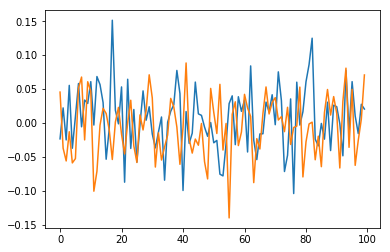

In [687]:
plt.plot(np.roll(init_cond[0:len(init_cond)/2],0))
plt.plot(np.roll(init_cond[len(init_cond)/2:],0))

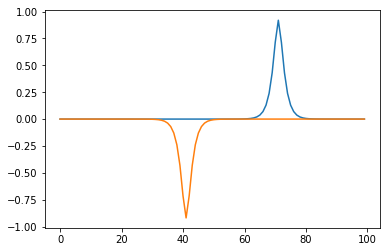

In [690]:
plt.plot(np.roll(sol_remi[-1,0:len(init_cond)/2],-10))
plt.plot(np.roll(sol_remi[-1,len(init_cond)/2:],-10))

### NOTE: This solution is destroyed and comes back to the total approximation with two and two peaks if we use the first order beta correction - why ?

## Perturb this state:

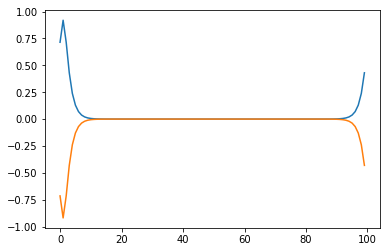

In [691]:
init_cond = 0.05*np.random.randn(2*n_v)
roll_val = np.argmax(abs(sol_remi[-1,0:len(init_cond)/2])) - np.argmax(abs(sol_remi[-1,len(init_cond)/2:]))
init_cond[0:len(init_cond)/2] = sol_remi[-1,0:len(init_cond)/2]
init_cond[len(init_cond)/2:] = np.roll(sol_remi[-1,len(init_cond)/2:],roll_val)
plt.plot(np.roll(init_cond[0:len(init_cond)/2],20))
plt.plot(np.roll(init_cond[len(init_cond)/2:],20))

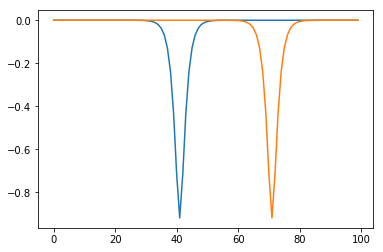

In [692]:
time_int = np.linspace(0,50000,10000)
sol_remi2 = odeint(Remi_Moshir2_full,init_cond,time_int,args=(0.1,))

plt.plot(np.roll(sol_remi2[-1,0:len(init_cond)/2],-0))
plt.plot(np.roll(sol_remi2[-1,len(init_cond)/2:],-0))

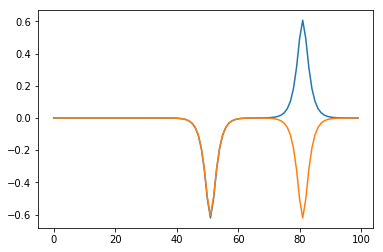

In [136]:
plt.plot(np.roll(sol_remi2[100,0:len(init_cond)/2],-0))
plt.plot(np.roll(sol_remi2[100,len(init_cond)/2:],-0))

## Calculate the eigenvalues of the Jacobian of the solution to check the stability: 

In [131]:
def jacobianEigenvalue(soln):
    
    fun2 = lambda y: np.append((np.roll(y[0:len(y)/2],1) + np.roll(y[0:len(y)/2],-1) + (y[0:len(y)/2]**3 - y[0:len(y)/2]*np.sum(y[0:len(y)/2]**2)) + y[0:len(y)/2]*(y[len(y)/2:]**2) - y[len(y)/2:]*np.sum(y[0:len(y)/2]*y[len(y)/2:])),(np.roll(y[len(y)/2:],1) + np.roll(y[len(y)/2:],-1) + (y[len(y)/2:]**3 - y[len(y)/2:]*np.sum(y[len(y)/2:]**2)) + y[len(y)/2:]*(y[0:len(y)/2]**2) - y[0:len(y)/2]*np.sum(y[0:len(y)/2]*y[len(y)/2:])))
    
    funFULL = lambda y: np.append( (np.roll(y[0:len(y)/2],1) + np.roll(y[0:len(y)/2],-1) + (y[0:len(y)/2]**3 - y[0:len(y)/2]*np.sum(y[0:len(y)/2]**2)) \
                                   - ((sc.tanh(y[len(y)/2:]*(beta**0.5)))*(1-(sc.tanh(y[0:len(y)/2]*(beta**0.5)))**2)\
                                      *(((np.prod(1 + sc.tanh(y[0:len(y)/2]*(beta**0.5))*sc.tanh(y[len(y)/2:]*(beta**0.5))))/(1 + sc.tanh(y[0:len(y)/2]*(beta**0.5))*sc.tanh(y[len(y)/2:]*(beta**0.5))))\
                                        -((np.prod(1 - sc.tanh(y[0:len(y)/2]*(beta**0.5))*sc.tanh(y[len(y)/2:]*(beta**0.5))))/(1 - sc.tanh(y[0:len(y)/2]*(beta**0.5))*sc.tanh(y[len(y)/2:]*(beta**0.5)))))/((np.prod(1 + sc.tanh(y[0:len(y)/2]*(beta**0.5))*sc.tanh(y[len(y)/2:]*(beta**0.5)))) + (np.prod(1 - sc.tanh(y[0:len(y)/2]*(beta**0.5))*sc.tanh(y[len(y)/2:]*(beta**0.5))))))/(beta**1.5)), \
                                  (np.roll(y[len(y)/2:],1) + np.roll(y[len(y)/2:],-1) + (y[len(y)/2:]**3 - y[len(y)/2:]*np.sum(y[len(y)/2:]**2)) \
                                   - ((sc.tanh(y[0:len(y)/2]*(beta**0.5)))*(1-(sc.tanh(y[len(y)/2:]*(beta**0.5)))**2)\
                                      *(((np.prod(1 + sc.tanh(y[0:len(y)/2]*(beta**0.5))*sc.tanh(y[len(y)/2:]*(beta**0.5))))/(1 + sc.tanh(y[0:len(y)/2]*(beta**0.5))*sc.tanh(y[len(y)/2:]*(beta**0.5))))\
                                        -((np.prod(1 - sc.tanh(y[0:len(y)/2]*(beta**0.5))*sc.tanh(y[len(y)/2:]*(beta**0.5))))/(1 - sc.tanh(y[0:len(y)/2]*(beta**0.5))*sc.tanh(y[len(y)/2:]*(beta**0.5)))))/((np.prod(1 + sc.tanh(y[0:len(y)/2]*(beta**0.5))*sc.tanh(y[len(y)/2:]*(beta**0.5)))) + (np.prod(1 - sc.tanh(y[0:len(y)/2]*(beta**0.5))*sc.tanh(y[len(y)/2:]*(beta**0.5))))))/(beta**1.5)) )
    
    funOrder1 = lambda y: np.append(((np.roll(y[0:len(y)/2],1) + np.roll(y[0:len(y)/2],-1) + (y[0:len(y)/2]**3 - y[0:len(y)/2]*np.sum(y[0:len(y)/2]**2)) + y[0:len(y)/2]*(y[len(y)/2:]**2) - y[len(y)/2:]*np.sum(y[0:len(y)/2]*y[len(y)/2:])) \
                                     + (2*beta*((y[0:len(y)/2]*y[len(y)/2:])*(y[0:len(y)/2] + y[len(y)/2:])*(np.sum(y[0:len(y)/2]*y[len(y)/2:])) - (y[0:len(y)/2]**2)*(y[len(y)/2:]**2)*(y[0:len(y)/2] + y[len(y)/2:])))),\
                                    ((np.roll(y[len(y)/2:],1) + np.roll(y[len(y)/2:],-1) + (y[len(y)/2:]**3 - y[len(y)/2:]*np.sum(y[len(y)/2:]**2)) + y[len(y)/2:]*(y[0:len(y)/2]**2) - y[0:len(y)/2]*np.sum(y[0:len(y)/2]*y[len(y)/2:])) \
                                     + (2*beta*((y[0:len(y)/2]*y[len(y)/2:])*(y[0:len(y)/2] + y[len(y)/2:])*(np.sum(y[0:len(y)/2]*y[len(y)/2:])) - (y[0:len(y)/2]**2)*(y[len(y)/2:]**2)*(y[0:len(y)/2] + y[len(y)/2:])))))
    
    t = nd.Jacobian(funOrder1)
    t_jac = t(soln)
    
    return np.linalg.eigvals(t_jac)

In [125]:
eVALs = jacobianEigenvalue(sol_remi[-1])
eVALs > 0

[[ -2.40008701e+00   9.99909523e-01  -4.85522738e-05 ...,   3.74354832e-04
    2.01050632e-04   1.07912901e-04]
 [  9.99909523e-01  -2.40012413e+00   9.99973945e-01 ...,   2.00895089e-04
    1.07892516e-04   5.79107574e-05]
 [ -4.85522738e-05   9.99973945e-01  -2.40013482e+00 ...,   1.07807538e-04
    5.78990088e-05   3.10769975e-05]
 ..., 
 [  3.74354832e-04   2.00895089e-04   1.07807538e-04 ...,  -2.39741477e+00
    9.95943198e-01  -2.17751113e-03]
 [  2.01050632e-04   1.07892516e-04   5.78990088e-05 ...,   9.95943198e-01
   -2.39932706e+00   9.98830525e-01]
 [  1.07912901e-04   5.79107574e-05   3.10769975e-05 ...,  -2.17751113e-03
    9.98830525e-01  -2.39987892e+00]]


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [130]:
print eVALs

[ -4.80024140e+00  -2.86811353e-15  -4.24502363e+00  -4.24498903e+00
  -4.27379703e+00  -4.27376045e+00  -4.29988468e+00  -4.29984794e+00
  -4.39854663e+00  -4.39850954e+00  -4.39377408e+00  -4.39373700e+00
  -4.38583763e+00  -4.38580057e+00  -4.32308326e+00  -4.32304642e+00
  -4.37476332e+00  -4.37472628e+00  -4.34333193e+00  -4.34329493e+00
  -4.36059892e+00  -4.36056239e+00  -4.35556086e+00  -4.35565345e+00
  -4.17866093e+00  -4.21300491e+00  -4.21296807e+00  -4.23225764e+00
  -4.23233654e+00  -4.14177610e+00  -4.14181158e+00  -4.17869659e+00
  -4.01517401e+00  -4.10240143e+00  -4.10243596e+00  -4.04801462e+00
  -4.06218048e+00  -4.06215993e+00  -3.23081987e-02  -3.23082002e-02
  -3.92084217e+00  -3.96892679e+00  -3.96889476e+00  -4.01513775e+00
  -4.04806058e+00  -3.92081020e+00  -3.87106560e+00  -3.87103926e+00
  -3.75943124e+00  -3.75939685e+00  -3.83140712e+00  -3.83139206e+00
  -3.80737083e+00  -3.80736135e+00  -3.70384933e+00  -3.70387300e+00
  -3.64876040e+00  -3.64878462e+00

In [137]:
eVALs2 = jacobianEigenvalue(sol_remi2[100])
eVALs2 > 0

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [140]:
print eVALs2

[-4.69183891 -4.17746563 -4.17746597 -4.35066831 -4.35066855 -4.3439595
 -4.34395974 -4.33281775 -4.332818   -4.33878399 -4.33878426 -4.21331108
 -4.21331141 -4.23074142 -4.23074124 -4.24545209 -4.2454518  -4.27350168
 -4.27350196 -4.31730943 -4.31730968 -4.29771918 -4.29771942 -4.29709588
 -4.29709611 -4.13697087 -4.13697117 -4.14269295 -4.1426929  -4.09459659
 -4.0945962  -4.04863796 -4.0486384   0.01410232  0.01820156 -4.03315009
 -3.9975592  -3.99755963 -3.94565915 -3.94565855 -4.03315041  0.01820308
 -3.90958802 -3.90958818 -3.82998366 -3.82998446 -3.886779   -3.88677853
 -3.77076793 -3.77966699 -3.77985155 -3.77340574 -3.70308321 -3.70308174
 -3.56204703 -3.56204637 -3.6430896  -3.6430904  -3.61162368 -3.61162237
 -3.75701026 -3.75701128 -0.19290166 -0.19269609 -3.50166788 -3.50166661
 -0.35437494 -3.4522622  -3.45226143 -3.34583874 -3.34583983 -3.41162985
 -3.41162945 -3.24255585 -3.24255595 -3.29362987 -3.29362868 -3.18738404
 -3.18738276 -0.35437519 -0.36339778 -0.36339878 -0.

In [147]:
eVALs3 = jacobianEigenvalue(sol_remiC[-1])
eVALs3 > 0

array([False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [148]:
print eVALs3

[ -4.78603489e+00   1.83079259e-03  -4.39819319e+00  -4.39244009e+00
  -4.38583453e+00  -4.38288115e+00  -4.38007904e+00  -4.37928569e+00
  -4.35249978e+00  -4.35717468e+00  -4.36689915e+00  -4.36954549e+00
  -4.37051613e+00  -4.34012160e+00  -4.33181478e+00  -4.27973763e+00
  -4.29509280e+00  -4.30749218e+00  -4.26732528e+00  -4.30629266e+00
  -4.31876492e+00  -4.31942736e+00  -4.24861524e+00  -4.16382895e+00
  -4.17629819e+00  -4.20136530e+00  -4.23618610e+00  -4.22330949e+00
  -4.21381575e+00  -4.21069087e+00  -3.99600539e+00  -4.13570360e+00
  -4.03217999e+00  -4.04473727e+00  -4.12320207e+00  -4.07764091e+00
  -4.09905936e+00  -4.08623314e+00  -4.09018955e+00  -3.98337626e+00
  -3.95189724e+00  -3.92581918e+00  -3.93879010e+00  -3.93851837e+00
  -3.26401347e-02  -1.86501641e-02  -3.88773301e+00  -3.87505524e+00
  -3.83282636e+00  -3.81999572e+00  -3.44769927e+00  -3.49476453e+00
  -3.50768399e+00  -3.70784874e+00  -3.69503851e+00  -3.64913301e+00
  -3.63602492e+00  -3.55361337e+00